In [1]:
import sys
COMP_NAME = "icecube-neutrinos-in-deep-ice"
sys.path.append(f"/home/anjum/kaggle/{COMP_NAME}/")

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

from src.config import INPUT_PATH, OUTPUT_PATH

In [2]:
_dtype = {
    "batch_id": "int16",
    "event_id": "int64",
    "first_pulse_index": "int32",
    "last_pulse_index": "int32",
#     "azimuth": "float32",
#     "zenith": "float32",
}

meta = pd.read_parquet(
    INPUT_PATH / "train_meta.parquet",
    columns=["batch_id", "event_id", "first_pulse_index", "last_pulse_index"],
).astype(_dtype)
meta.shape

(131953924, 4)

In [3]:
meta["n_pulses"] = meta["last_pulse_index"] - meta["first_pulse_index"]
meta.head()

,batch_id,event_id,first_pulse_index,last_pulse_index,n_pulses
0,1,24,0,60,60
1,1,41,61,111,50
2,1,59,112,147,35
3,1,67,148,289,141
4,1,72,290,351,61


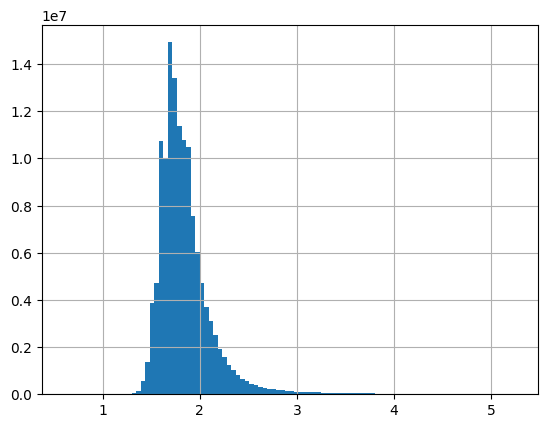

In [4]:
np.log10(meta["n_pulses"]).hist(bins=100);

In [5]:
meta["bins"] = pd.qcut(np.log10(meta["n_pulses"]), 10, labels=False)
meta["bins"].value_counts()

2    15116423
0    14728439
4    14278994
7    13608356
9    13145685
5    12949389
8    12755626
6    11848669
3    11792628
1    11729715
Name: bins, dtype: int64

In [6]:
# How many events with > n pulses?
meta[meta["n_pulses"] > 1000].shape

(1483567, 6)

In [7]:
meta[meta["bins"] == 9]["n_pulses"].agg(['max', 'min', "median"])

max       178249.0
min          144.0
median       221.0
Name: n_pulses, dtype: float64

In [8]:
meta[meta["bins"] == 8]["n_pulses"].agg(['max', 'min', "median"])

max       143.0
min       100.0
median    115.0
Name: n_pulses, dtype: float64

In [9]:
meta.query("n_pulses == 178249")

,batch_id,event_id,first_pulse_index,last_pulse_index,n_pulses,bins
122823323,615,1999013610,3827530,4005779,178249,9


In [27]:
# meta[meta["bins"] == 4]
avg_event = pd.read_parquet(INPUT_PATH / "train" / "batch_1.parquet").loc[663]
avg_event

,sensor_id,time,charge,auxiliary
event_id,,,,
663,116,5952,0.425,True
663,714,6479,0.875,True
663,3804,6643,0.425,True
663,4243,6649,0.575,True
663,5095,6909,1.025,True
...,...,...,...,...
663,588,16183,1.375,True
663,1082,16456,1.175,True
663,4359,16462,1.275,False


In [10]:
big_event = pd.read_parquet(INPUT_PATH / "train" / "batch_615.parquet")
big_event = big_event.loc[1999013610]
big_event.shape

(178250, 4)

In [11]:
big_event["auxiliary"].value_counts()

False    177904
True        346
Name: auxiliary, dtype: int64

In [12]:
big_event.head()

,sensor_id,time,charge,auxiliary
event_id,,,,
1999013610,3712,6561,0.525,True
1999013610,3602,6695,0.875,True
1999013610,777,6889,1.075,True
1999013610,1487,7398,0.725,True
1999013610,3787,7705,0.875,True


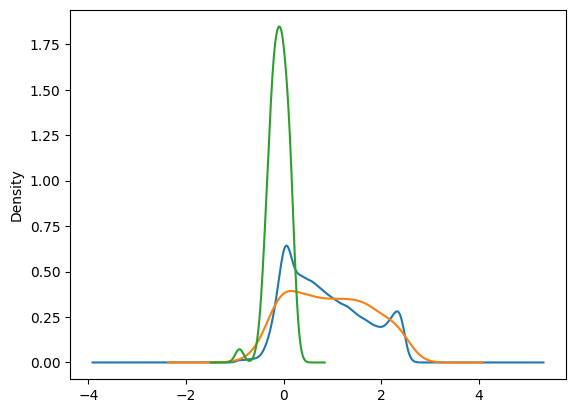

In [28]:
# np.log10(big_event["charge"]).hist(bins=100);
np.log10(big_event["charge"]).plot.kde();
# np.log10(big_event["charge"].sample(1000)).hist(bins=100);
np.log10(big_event["charge"].sample(250)).plot.kde()

np.log10(avg_event["charge"]).plot.kde();

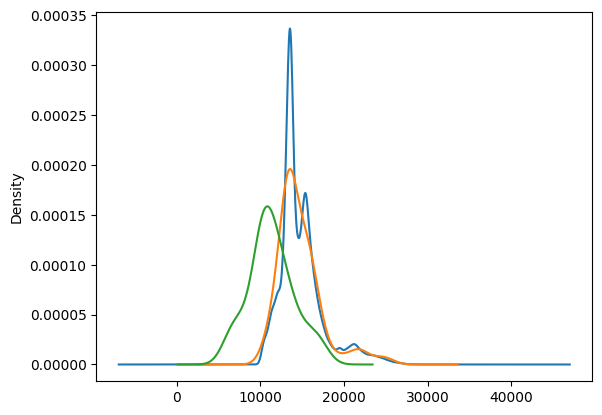

In [29]:
big_event["time"].plot.kde();
big_event["time"].sample(250).plot.kde();
avg_event["time"].plot.kde();

In [45]:
data = torch.load(INPUT_PATH / "train_events" / "batch_615" / "event_1999013610.pt")

In [46]:
data

Data(x=[178250, 7], y=[2], n_pulses=178250)

In [47]:
data.x[:, -1]

tensor([ 0.5000, -0.5000, -0.5000,  ...,  0.5000,  0.5000,  0.5000])

In [48]:
mask = data.x[:, -1] < 0
data.x = data.x[mask]
data.n_pulses = data.x.shape[0]
data

Data(x=[177904, 7], y=[2], n_pulses=177904)

In [49]:
data.x.shape[0]

177904

In [50]:
data.x = data.x[np.random.choice(data.n_pulses, 300)]
data.n_pulses = 300